<a href="https://colab.research.google.com/github/manthanthakker/DeepNeuralNetworks/blob/master/TransferLearningPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning - Hot Dog or Not a Hot Dog 

## Reusable Utlities

In [101]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode
!pip install cykooz.heif
!pip install split-folders tqdm


#### Image Processing - PreProcessing
Applies transformers and prepare the dataset into a common strucuture
The input folder shoud have the following format:



```
input/
    class1/
        img1.jpg
        img2.jpg
        ...
    class2/
        imgWhatever.jpg
        ...
    ...
```



```
output/
    train/
        class1/
            img1.jpg
            ...
        class2/
            imga.jpg
            ...
    val/
        class1/
            img2.jpg
            ...
        class2/
            imgb.jpg
            ...
    test/
        class1/
            img3.jpg
            ...
        class2/
            imgc.jpg
            ...
```


Enter the input/ path in the path variable when prompted




In [0]:
from PIL import Image  # Python Image Library - Image Processing
import glob

In [0]:
import os
## Creates a new Directory if it does not exist
def makeDirectory(dir):
  if not os.path.exists(dir):
    os.makedirs(dir)

## Creates a new Directory with "Preprocessed subfolder in the same root directory" 
def getDestinationPath(path):
  destinationFolder=os.path.dirname(path)+"-Preprocessed"
  destinationPath=os.path.dirname(path)
  destination=os.path.join(destinationPath,destinationFolder)
  return destination

## Apply a transformer to classpath and output is store in destination path
def applyTransformerToEachFolder(classPath,destination,transformer):
  files=os.listdir(classPath)
  for eachFile in files:
    if  not eachFile.startswith("."):
      transformer(classPath,eachFile,destination,eachFile)

def preprocess(path,transformer):

  ## Create a subdirectory with preprocessed
  destination=getDestinationPath(path)
  makeDirectory(destination)

  ## Apply a transformer to each File in the nested structure
  ## Output to be store in clone directory structure with preprocessed keyword
  for eachclass in os.listdir(path):
    if  not eachclass.startswith("."):
      cloneClassDir=os.path.join(destination,eachclass)
      makeDirectory(cloneClassDir)
      applyTransformerToEachFolder(path+eachclass,cloneClassDir,transformer)

  ## Prepare the folder structure for Pytorch Transfer learning
  import split_folders
  print("Splitting into Train,Test and val dataaset")
  split_folders.ratio(destination, output=destination, seed=1337, ratio=(.8, .2)) # default values
  return destination
      
## Transformer
def convertImageToJpg(imagePath,imageName,destination,destinationImageName):
  from PIL import Image  # Python Image Library - Image Processing
  import glob
  from pathlib import Path
  from cykooz.heif.pil import register_heif_opener

  register_heif_opener()
  im = Image.open(os.path.join(imagePath,imageName))
  rgb_im = im.convert('RGB')
  destinationPath=os.path.join(destination,destinationImageName)
  pathNamewithJpg=os.path.splitext(destinationPath)[0]+".jpeg"
  rgb_im.save(pathNamewithJpg)


#### Some Common Path Operations (Optional)

In [104]:
path="/transferlearning/manthan/IMG_0459.heic"
import os
from pathlib import Path

p=Path(path)

print(os.path.abspath(p))
print(os.path.basename(p))
print(os.path.basename(p)+"-Proce")
print(os.path.dirname(p)+"-press")
print(os.path.isdir(p))

print(os.path.join(p,"manth","high"))
print(os.path.normcase(p))
print(os.path.relpath(p,"drive/My Drive/ML/data/"))

print(os.path.splitext(p)[0])

/transferlearning/manthan/IMG_0459.heic
IMG_0459.heic
IMG_0459.heic-Proce
/transferlearning/manthan-press
False
/transferlearning/manthan/IMG_0459.heic/manth/high
/transferlearning/manthan/IMG_0459.heic
../../../../../transferlearning/manthan/IMG_0459.heic
/transferlearning/manthan/IMG_0459


#### Unzip Dataset (optional)

In [0]:
# import zipfile
# with zipfile.ZipFile("/content/drive/My Drive/ML/data/siliconvalley/hot-dog-not-hot-dog.zip", 'r') as zip_ref:
#     zip_ref.extractall("/content/drive/My Drive/ML/data/siliconvalley/")
#     zip_ref.close()

#### Visualize Image

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

#### Resnet Architecture

In [107]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Resuable Visualize Validation Set for model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#### Resulable Training Routine for Pytorch

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #print(labels)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Dowload Data and Prepare for Training

In [0]:
## Step1: Dowload Data from Kaggle: https://www.kaggle.com/dansbecker/hot-dog-not-hot-dog

## Step2: Upload the data from your local desktop to colab/drive 
## Note you can use Kaggle CLI/Wget too, but to avoid authetication, using this.

# from google.colab import files
# zipFileData=files.upload()

## Step3: Unzip zipfile using this utility

# import zipfile
# zipFileName=zipFileData.items()[09]
# with zipfile.ZipFile(zipFileName, 'r') as zip_ref:
#     zip_ref.extractall(file_path+"/data/")
#     zip_ref.close()

## Step4: After the above steps you should have mutiple folder in file_path 
## with files belonging to each class, Provide the filePath in file_path parameter

#@markdown ### Enter a file path which is a valid google drive folder path:
file_path = "/content/drive/My Drive/ML/data/siliconvalley-Preprocessed" #@param {type:"string"}

## Step5: Call the preprocessor -- for this data set we can avoid preprocessing 
## as we already have preprocessed data
#data_dir= preprocess(file_path,convertImageToJpg)
data_dir=file_path

## After step5: You will notice a new folder preprocessed has been created
## inside the root directory, simply note this. 

#### Pytorch Routine - Datasets Iterable, Loader, setting up device etc


In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
# Step6: Now, lets load the datasets and make datasets iterable
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#data_dir = '/content/drive/My Drive/ML/data/siliconvalley-Preprocessed'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Visualize Some Random Training Data

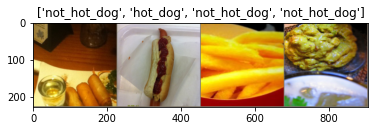

In [112]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## ResNet - Train All Layers

In [113]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.6946 Acc: 0.6466
val Loss: 0.4107 Acc: 0.8120

Epoch 1/4
----------
train Loss: 0.5778 Acc: 0.7470
val Loss: 0.4150 Acc: 0.8200

Epoch 2/4
----------
train Loss: 0.7427 Acc: 0.6867
val Loss: 0.8681 Acc: 0.6420

Epoch 3/4
----------
train Loss: 0.7324 Acc: 0.7068
val Loss: 0.4857 Acc: 0.8240

Epoch 4/4
----------
train Loss: 0.5768 Acc: 0.7450
val Loss: 0.4372 Acc: 0.8240

Training complete in 2m 1s
Best val Acc: 0.824000


Lets visualize

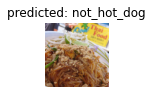

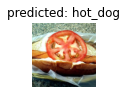

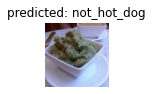

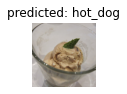

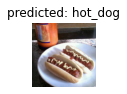

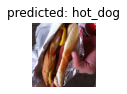

In [114]:
visualize_model(model_ft)
plt.ioff()
plt.show()

## ResNet - Fixed Layers

In [115]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.7163 Acc: 0.5703
val Loss: 0.3300 Acc: 0.8580

Epoch 1/4
----------
train Loss: 0.6174 Acc: 0.7108
val Loss: 0.3273 Acc: 0.8640

Epoch 2/4
----------
train Loss: 0.6415 Acc: 0.7149
val Loss: 0.4181 Acc: 0.8100

Epoch 3/4
----------
train Loss: 0.7738 Acc: 0.6787
val Loss: 0.6822 Acc: 0.7060

Epoch 4/4
----------
train Loss: 0.7055 Acc: 0.7068
val Loss: 0.3373 Acc: 0.8720

Training complete in 0m 35s
Best val Acc: 0.872000


Visualize results

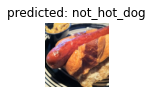

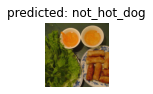

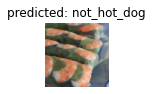

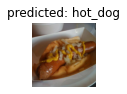

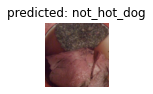

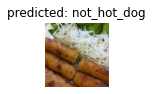

In [116]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Thats it we have explore Transfer Learning by customizing ResetNet for identifying Custom object